# Support Vector Machines to predict stable crystal compositions

In this notebook you will work with three datafiles: ex6data1.dat, ex6data2.dat and ex6data3.dat. They contain information about experiments of a three hypothetical materials: Simpilian, Complexian, Absurdian as function of their composition presented by coordinates (X1,X2). The material can either form a form a 'good' single homogeneous crystal (1) or have decomposed in a 'bad' poly-crystalline sample (-1). It is your task to find the boundary between these two phases based on a finite experimental dataset. The complexity of the decision boundary grows from example 1 to 3. The data is linearly separable in ex.1 and 2 by either a straight line or a curvy line, respectively. In example 3 you will encounter that the experimental data close to the decision boundary is diffuse or contains noise/errors.


## Part 1. The Genetic Algorithm

We are going to start by coding a general genetic algorithm that can be used to maximize an arbitrary fitness function. You will first test your code by maximizing 

$$f(\boldsymbol{\theta})=-(\theta_0-10)^2-(\theta_0-\theta_1)^2-(\theta_0-\theta_1-\theta_2-3)^2$$. 

Derive the solution analytically yourself. <em>Answer:</em> $\boldsymbol{\theta} =\{10,10,-3\}$. 

In [3]:
# importing the required modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

# to get matplot figures render correctly in the notebook use:
%matplotlib inline 

In [4]:
def f(theta):
    """
    computes the fitness of individual with genome theta according to the equation
    fitness = -(theta[0]-10)^2 - (theta[0]-theta[1])^2 - (theta[0]-theta[1]-theta[2]-3)^2 

    Parameters
    ----------
    theta : (3,) ndarray of float (the genome of the individual)

    Returns
    -------
    fitness : float
        The fitness of theta

    """

    fitness = -((theta[0] - 10) ** 2) - ((theta[0] - theta[1]) ** 2) - ((theta[0] - theta[1] - theta[2] - 3) ** 2)

    return fitness

We define $K$ vectors $\boldsymbol{\theta}_k$, $k=0, \ldots, K-1$ that serve all as approximations of the real maximum. Every vector in this collection has a certain fitness $f_k = f(\boldsymbol{\theta}_k)$. We will apply a genetical algortithm in this notebook, in which each $\boldsymbol{\theta}_k$ is an **indiviual**.

For the time being assume these vectors are sorted according decreasing fitness. So $\boldsymbol{\theta}_0$ has the largest fitness $f_0$ and $\boldsymbol{\theta}_{K-1}$ the lowest fitness $f_{K-1}$. Genetically the vector $\boldsymbol{\theta}_0$ is stronger $\boldsymbol{\theta}_1$, etc.

After initializing a population with random **genomes** and sorting them according to fitness, we are going to generate a new population, again of size $K$. (You will see that there are quite some choices to be made in the sequal, but, strangely enough, it does not matter so much how you choose them: this genetic algorithm works 'all the time'.) 
We need two functions  `cross(theta1, theta2)` and   `mutate(theta)` in order to generate a new population.

- The function `cross(theta1, theta2)` combines individuals $theta1, theta2$, to a new genome/individual  
- The function `mutate(theta)` mutates individual $theta$


In [5]:
rng = np.random.default_rng()


def cross(theta1, theta2):
    """
    generates a new individual by crossing genes from individuals theta1 and theta2 
    by taking half the genes (randomly chosen) from theta1 and the others from theta2

    Parameters
    ----------
    theta1, theta2 : (N,) ndarray of float (N is the number of genes of the genomes)
        The two indivuals/genomes that will be crossed

    Returns
    -------
    crossed_theta : (N,) ndarray of float (N is the number of genes of the genomes)
        The new individual/genome

    """

    crossed_theta = np.zeros_like(theta1)

    # Select a random crossover point
    crossover_point = rng.integers(0, len(theta1))

    # Copy the first half of parent 1's genes into the child
    crossed_theta[:crossover_point] = theta1[:crossover_point]

    # Copy the second half of parent 2's genes into the child
    crossed_theta[crossover_point:] = theta2[crossover_point:]

    return crossed_theta


def mutate(theta):
    """
    mutates an individual theta by adding a randomly chosen values to randomly chosen genes 

    Parameters
    ----------
    theta : (N,) ndarray of float (N is the number of genes of the individual)
        The individual/genome that gets mutated

    Returns
    -------
    mutated_theta : (N,) ndarray of float (N is the number of genes of the individual)
        The new individual/genome

    """

    mutated_theta = theta + rng.normal(0, 0.1, size=theta.shape)

    return mutated_theta

These functions allow us to combine genomes of individuals. We of course now need a strategy **which individuals** are going to take part in it. As a first attempt, lets test the following genetic algorithm:

As the individuals with a low index are strong, we let the strongest $25\%$ be part of the new population as well.

For the other $75\%$ we are going to combine the genomes of two parents, $A, B$, giving an individual (offspring) $C$ with  

| range | A: parent 1 | B: parent 2 | C: offspring |
|---|:---:|:---:|:-------------------------------------------------------------------------------:|
|$$\text{first }25\%$$ | none |  none | $$\boldsymbol{\theta}_k, \text{with }k=0..K/4-1$$ | 
|$$\text{second }25\%$$ | $$\boldsymbol{\theta}_k$$ | $$\boldsymbol{\theta}_{k+1}$$ | $$\text{cross(A,B) + mutate, } k=0..K/4-1$$ |
|$$\text{third } 25\%$$ | $$\boldsymbol{\theta}_k$$ | $$\boldsymbol{\theta}_r$$ | $$\text{cross(A,B) + mutate, } k=0..K/4-1, r \text{ is random}$$|  
|$$\text{fourth } 25\%$$ | $$\boldsymbol{\theta}_r$$ | $$\boldsymbol{\theta}_s$$ | $$\text{cross(A,B) + mutate, } r \text{ and } s \text{ taken random}$$ | 

For convenience we take $K$ to be a multiple of $4$, so it will be straightforward to split the population in the 4 groups. And again: change the rules and see if you can do better than my first attempt!

The resulting algorithm may seem to be slow. However, if the number of parameters becomes (much) larger the algorithm still works more or less at the same speed.

In [6]:
def cross_and_mutate(population):
    """
    generates a new population of individuals by crossing and mutating 

    Parameters
    ----------
    population : (K, N) ndarray of float (K is the number of individuals, N is the number of genes of the individual)
        The population used to generate the new population. The population is assumed to be in order of fitness

    Returns
    -------
    offspring : (K, N) ndarray of float (see above)
        The new population

    """

    K = population.shape[0]
    N = population.shape[1]

    offspring = np.zeros_like(population)

    # First 25%
    offspring[:K // 4] = population[:K // 4]

    # Second 25%
    offspring[K // 4:K // 2] = mutate(cross(population[K // 4:K // 2], population[K // 4 + 1:K // 2 + 1]))

    # Third 25%
    random1 = rng.choice(population, K // 4)
    offspring[K // 2:K - (K // 4)] = mutate(cross(population[K // 2:K - (K // 4)], random1))

    # Fourth 25%
    random2 = rng.choice(population, K // 4)
    random3 = rng.choice(population, K // 4)
    offspring[K - (K // 4):] = mutate(cross(random2, random3))

    return offspring

In [7]:
def run(f, K, N, num_generations = 1000):
    """
    executes the genetic algorithm to maximize a fitness function 

    Parameters
    ----------
    f: function:  returns a fitness value and has as argument an individual/genome (ndarray of shape (N,))
    K: integer : size of the population (multiple of 4)
    N: integer : number of genes in an individual
    num_generations: integer : number of generation that are executed

    Returns
    -------
    (theta, fitness_history): tuple
        theta: ndarray(N,) of float representing the individual.genome that yielded the best fitness
        fitness: ndarray(num_generations, ) of float the best fitness after each generation

    """

    # make sure K is always a multiple of 4, if not: raise an exception
    if K % 4 != 0:
        raise ValueError('K should be a multiple of 4')

    population = rng.standard_normal((K, N))
    fitness_history = np.zeros(num_generations)

    for i in range(num_generations):
        offspring_population = cross_and_mutate(population)
        combined_population = np.concatenate((population, offspring_population))
        fitness = np.array([f(individual) for individual in combined_population])
        sorted_indices = np.argsort(-fitness)
        population = combined_population[sorted_indices[:K]]
        fitness_history[i] = fitness[sorted_indices[0]]

    theta = population[0]

    return(theta, fitness_history)

Theta: [10.00407888 10.00850655 -2.99998986]


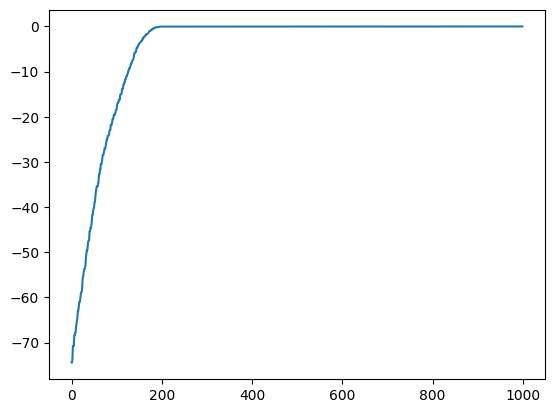

In [8]:
# execute the genetic algorithm

K = 24  # population size
N = 3  # number of genes in the genome
num_generations = 1000

theta, fitness = run(f, K, N, num_generations)

print(f"Theta: {theta}")

plt.plot(fitness)  # plot the evolution of the fitness
plt.show()

This should converge to fitness = 0 best genome  $\boldsymbol{\theta} = [10, 10, -3]$

## Part 2. The Support Vector Machine


**We have now setup the algorithm an now apply it to data sets:**

- The first we do by using a package **sklearn**. 
- Second, we will solve it by using the genetic algorithm. 
- Later on you will use the package **sklearn** on more difficult data sets (to write a code that does what **sklearn** can do will take many ECs....


The data sets below will be data in 2D with two types: $y=1$ and $y=-1$ . 

### Example Dataset 1: Material Simpilian

In [9]:
# below two plot functions are defined that help visulaizing the results and the dataset.
# one for plotting the data and the decision boundary and margins of the SVM solution
# one for plotting the data and the results from the SVM from sklearn

def plotdata(X, y, theta=None):
    """
    plots the data and optionally the decision boundary and margins 

    Parameters
    ----------
    X: ndarray of size (M, 2) : data, with M the number of samples and 2 features
    y: ndarray of size (M,) :  labels of the datapoints (either 1 or other)
    theta: ndarray(3,) : solution of the SVM decision boundary theta[0] = bias, theta[1] and theta[2] are the weights
                        if None (default) no baoundary is plotted

    Returns
    -------
    None
    """
    mask = y == 1
    plt.scatter(*X[mask, :].T, s=50, c='k', marker='+', label='1')
    plt.scatter(*X[~mask, :].T, s=50, c='y', marker='o', label='-1')

    # optionally plot decision boundary 
    if theta is not None:
        x = np.linspace(min(X[:, 0]), max(X[:, 0]), 10)
        b, w1, w2 = theta
        y_db = -w1 / w2 * x - b / w2  # see eq 4.5 reader
        # margins
        y_margin1 = y_db + 1 / w2  # see eq. 4.9 reader with gamma=1
        y_margin2 = y_db - 1 / w2
        plt.plot(x, y_db, label='decision boundary')
        plt.plot(x, y_margin1, ':r', label='margins')
        plt.plot(x, y_margin2, ':r')

    plt.legend()
    plt.xlabel('x1')
    plt.ylabel('x2')


def plot_svc(svc, X, y):
    """
    plots the results from the sklearn SVM fit

    Parameters
    ----------
    svc: instance of sklearn.svm._classes.SVC
    X: ndarray of size (M, 2) : data, with M the number of samples and 2 features
    y: ndarray of size (M,) :  labels of the datapoints (either 1 or other)

    Returns
    -------
    None
    """
    # first plot the data and decisionboundary
    plotdata(X, y)
    DecisionBoundaryDisplay.from_estimator(clf, X, ax=plt.gca(), alpha=0.4, cmap=plt.cm.Paired, response_method="predict")

    # plot the supportvectors
    plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], c='k', marker='|', s=100, linewidths=1)
    plt.title(f'C={svc.C}; Number of support vectors: {svc.support_.size}')

    plt.xlabel('x1')
    plt.ylabel('x2')

First read the dataset and inspect the data and make a plot.

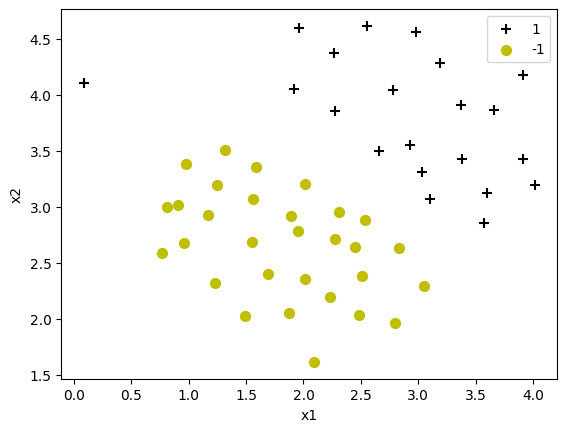

In [10]:
FILENAME = 'data/ex6data1.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)

# split the data in features and labels
X1 = data[:, :2]
y1 = data[:, 2]

# make a plot of the data
plotdata(X1, y1)

We first make the data set a little simpler: the point on the left changes identity ($1 \to -1$)

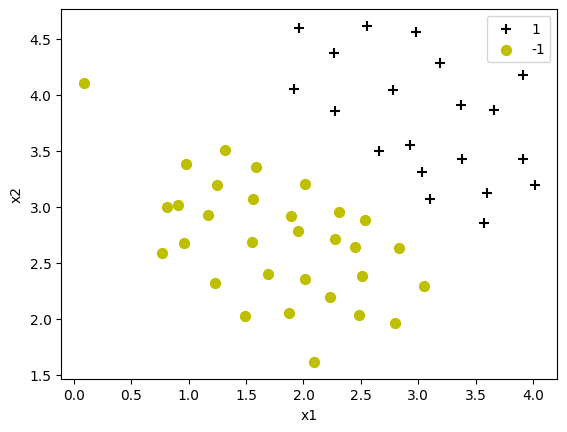

In [11]:
y1[50] = -1
plotdata(X1, y1)

This is what SVC from the package does. What is the function of the parameter C?

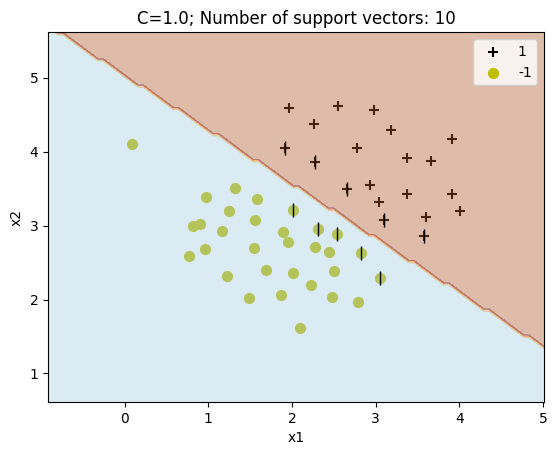

In [12]:
clf = SVC(C=1.0, kernel='linear')
clf.fit(X1, y1)
plot_svc(clf, X1, y1)

# C is the regularization parameter. The strength of the regularization is inversely proportional to C

**Implement the optimalisation as as defined below using the genetic algorith that we already have in the run() function. You can also find it in Eq. (4.12)of the lecture notes or (7.3) in Bishop.**

Find $\mathbf{w}$ and $b$ that maximize the margin, while correctly classify all data:<br>
  argmax$_{\mathbf{w},b} \left \{ \frac{1}{\| \mathbf{w} \|} \displaystyle \min_m \left \{ y^{(m)} \left ( \mathbf{w}^T \mathbf{x}^{(m)} + b \right) \right \} \right \},\;\; $
    $ \text{subject to }y^{(m)} \left ( \mathbf{w}^T \mathbf{x}^{(m)} + b \right) \geq 0$
    
What is the fitness when the hyperplane of your SVM does not properly classify all points? Add a penelaty term to the fitness function that adds a penealty of size C for each misclassification, or use the hinge loss function (this is the better choice).

solution: theta = [-8.05124082  0.98240529  1.76627462]


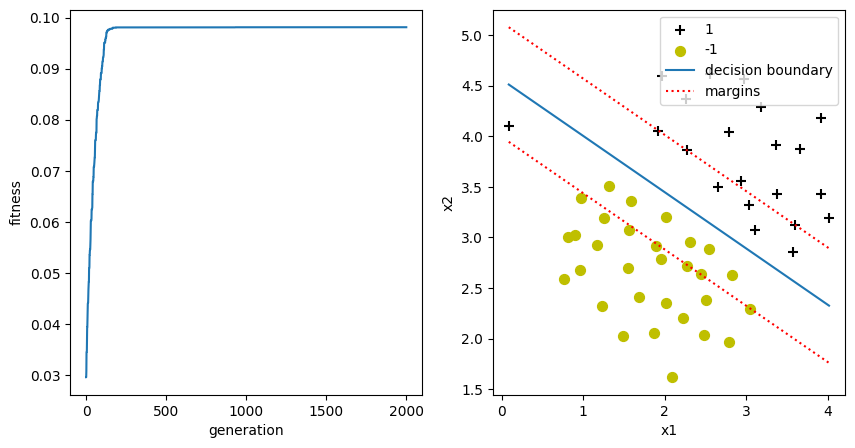

In [17]:
def fSVM(theta):
    """
    computes the fitness of individual theta for a SVM classifier
    see for example the loss function as defined in eq 4.16 of the reader or (7.3) in Bishop
    Requires/assumes the presence of the global variables X and y that define the dataset 

    Parameters
    ----------
    theta : (3,) ndarray of float (the genes/parameters of the individual including the bias theta[0] and the two weights theta[1] and theta[2])

    Returns
    -------
    fitness : float
        The fitness of theta

    """

    b, w1, w2 = theta

    loss = np.maximum(0, 1 - y * (w1 * X[:, 0] + w2 * X[:, 1] + b))
    reg_term = np.sum(theta[1:]**2)

    total_loss = np.sum(loss) + reg_term
    fitness = 1 / total_loss

    return fitness


# define X and y as required by the fitness function
X = X1
y = y1

# execute the genetic algorithm
K = 100  # population size
N = 3    # number of genes in the genome
num_generations = 2000

theta, fitness = run(fSVM, K, N, num_generations)

# print/plot the results
print(f'solution: theta = {theta}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax1)
plt.plot(fitness)
plt.xlabel('generation')
plt.ylabel('fitness')

plt.sca(ax2)
plotdata(X1, y1, theta)

We will now switch back the classification of that single data point. How does this affect your hyperplane?

In [23]:
y1[50] = 1

solution: theta = [-8.03668678  0.98367016  1.7608338 ]


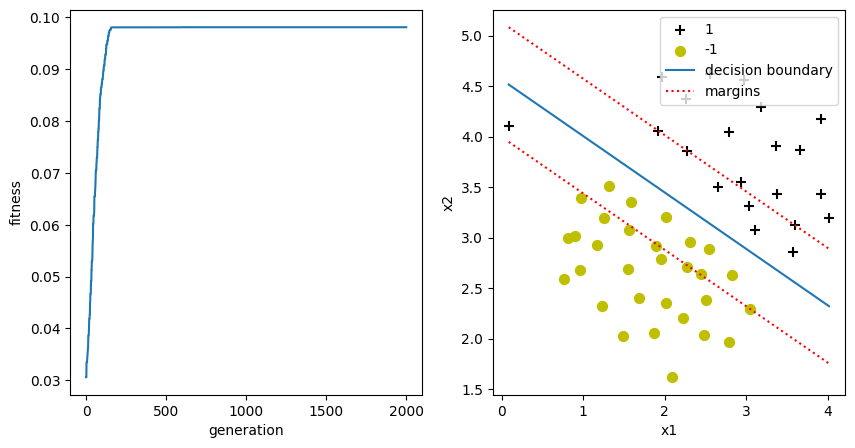

In [24]:
# define X and y as required by the fitness function
X = X1
y = y1

# execute the genetic algorithm
K = 100  # population size
N = 3  # number of genes in the genome
num_generations = 2000

theta, fitness = run(fSVM, K, N, num_generations)

# print/plot the results
print(f'solution: theta = {theta}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax1)
plt.plot(fitness)
plt.xlabel('generation')
plt.ylabel('fitness')

plt.sca(ax2)
plotdata(X1, y1, theta)

In [ ]:
# The hyperplane is moved down to include the changed datapoint.

Do the same but now with the sklearn functions. Compare different values of C

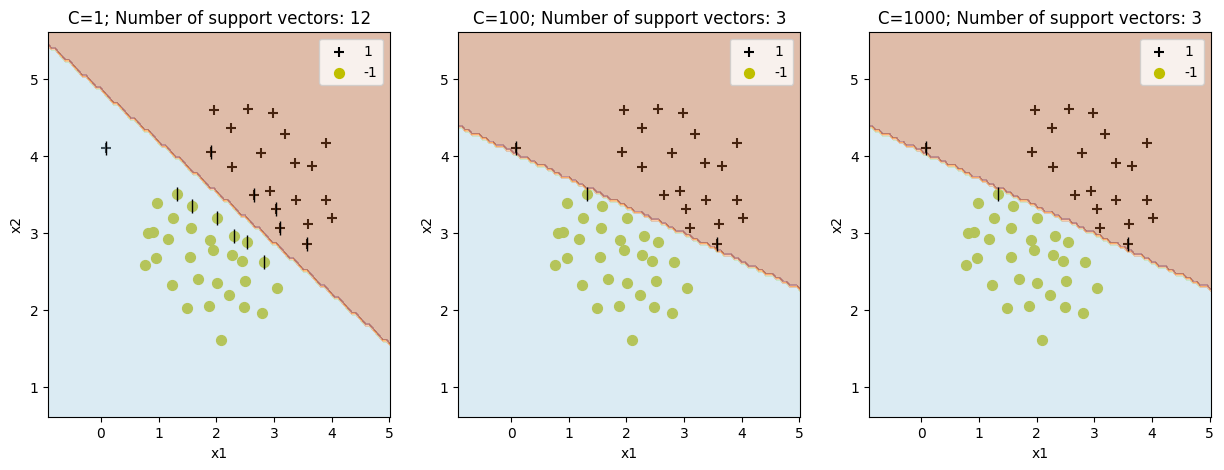

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

clf = SVC(C=1, kernel='linear')
clf.fit(X1, y1.ravel())
plt.sca(ax1)
plot_svc(clf, X1, y1)

clf = SVC(C=100, kernel='linear')
clf.fit(X1, y1.ravel())
plt.sca(ax2)
plot_svc(clf, X1, y1)

clf = SVC(C=1000, kernel='linear')
clf.fit(X1, y1.ravel())
plt.sca(ax3)
plot_svc(clf, X1, y1)

**Question.** Does the linear case work for C->0 and/or C->infinity work for the case that the dataset is not linearly separable? And what about the genetic code?
(set, e.g., the `X1[50,1] = 3` and `y1[50] = 1`)
How would you rephrase the genetic optimization such that you could use it for the non separable case as well?

In [ ]:
# The linear case does not work for for either C values if the dataset is not linearly separable.
# C->0 will lead to underfitting, C->infinity to overfitting.
# An alternative kernel could be used to work for non-separable cases.

### SVM with other Kernels

Below are two more data sets. Use the package sklearn for this. Dive into the manual of this package an figure out how you can get a good classifier. Explain how the methods works with other kernels. Change parameters, such as C, degree and other basis functions: what is their effect? 

#### Example Dataset 2: Material Complexian

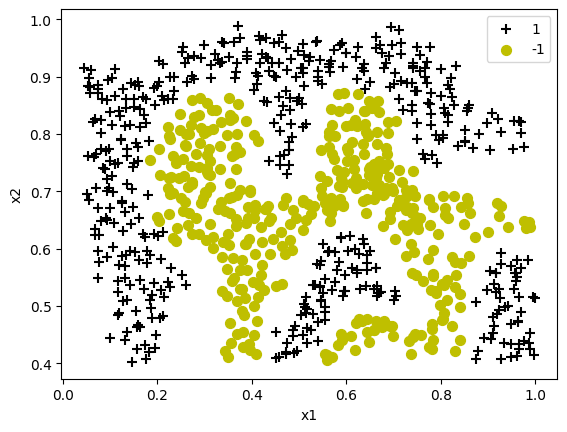

In [28]:
FILENAME = 'data/ex6data2.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)
X2 = data[:, :2]
y2 = data[:, 2]

plotdata(X2, y2)

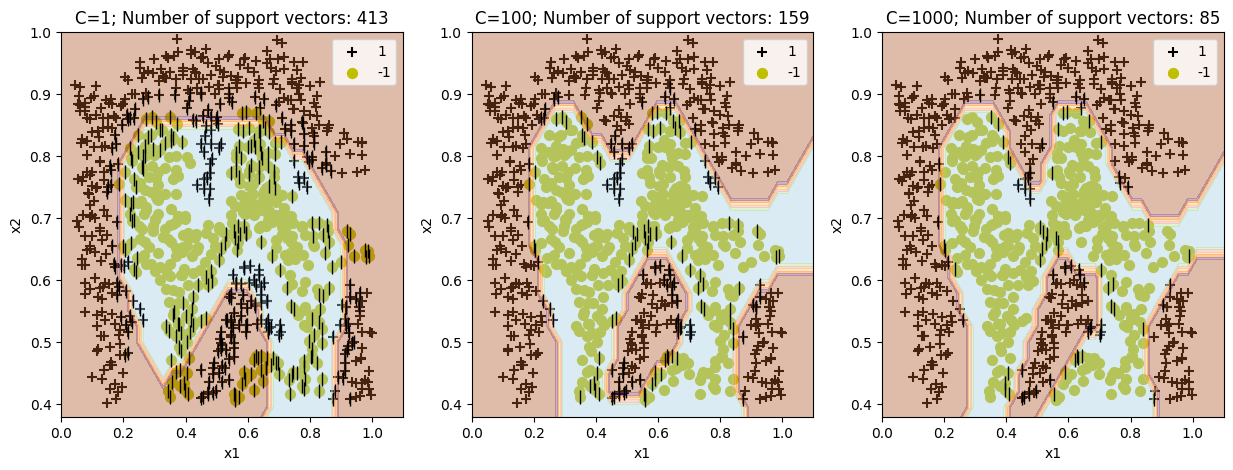

In [41]:
# write your code here
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

clf = SVC(C=1, kernel='rbf')
clf.fit(X2, y2.ravel())
plt.sca(ax1)
plot_svc(clf, X2, y2)

clf = SVC(C=100, kernel='rbf')
clf.fit(X2, y2.ravel())
plt.sca(ax2)
plot_svc(clf, X2, y2)

clf = SVC(C=1000, kernel='rbf')
clf.fit(X2, y2.ravel())
plt.sca(ax3)
plot_svc(clf, X2, y2)

ax1.set_xlim(0, 1.1)
ax1.set_ylim(0.38, 1)

ax2.set_xlim(0, 1.1)
ax2.set_ylim(0.38, 1)

ax3.set_xlim(0, 1.1)
ax3.set_ylim(0.38, 1)

plt.show()

# Increasing C also increases the accuracy of the method. Changing the kernel completely changes the method.
# RBF was the most accurate method I could find.

#### Example Dataset 3: Material Absurdian

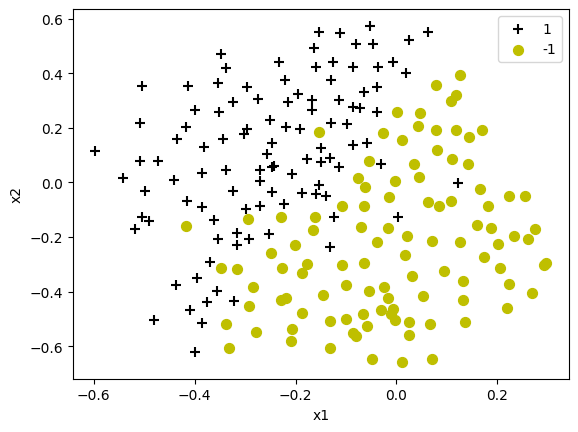

In [42]:
FILENAME = 'data/ex6data3.txt'  # points to the datafolder; either a relative or absolute path
DELIMITER = ','  # we use a lot of csv or txt files where the data is separated by a comma

data = np.loadtxt(FILENAME, delimiter=DELIMITER)
X3 = data[:, :2]
y3 = data[:, 2]

plotdata(X3, y3)

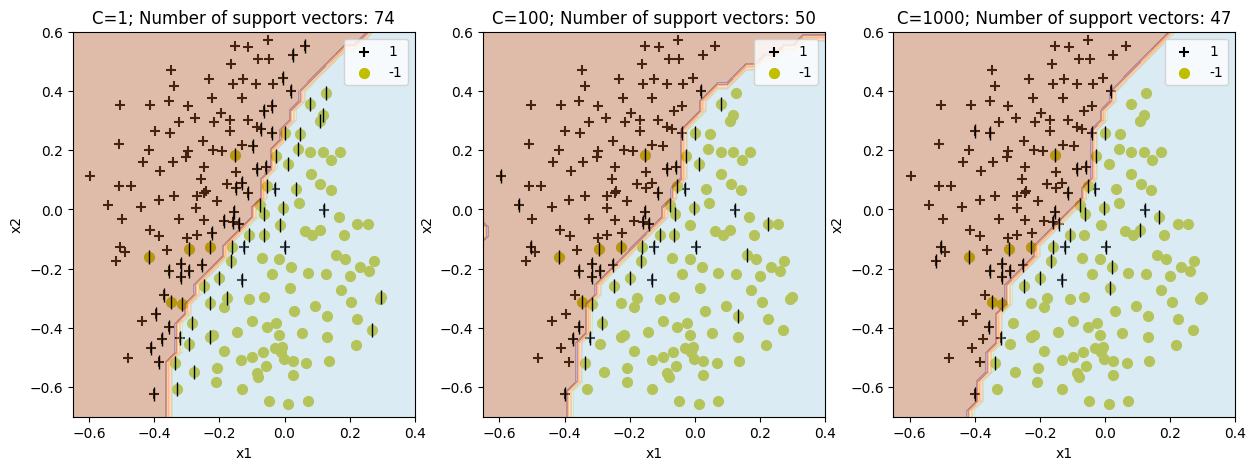

In [55]:
# write your code here
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

clf = SVC(C=1, kernel='rbf')
clf.fit(X3, y3.ravel())
plt.sca(ax1)
plot_svc(clf, X3, y3)

clf = SVC(C=100, kernel='rbf')
clf.fit(X3, y3.ravel())
plt.sca(ax2)
plot_svc(clf, X3, y3)

clf = SVC(C=1000, kernel='rbf')
clf.fit(X3, y3.ravel())
plt.sca(ax3)
plot_svc(clf, X3, y3)

ax1.set_xlim(-0.65, 0.4)
ax1.set_ylim(-0.7, 0.6)

ax2.set_xlim(-0.65, 0.4)
ax2.set_ylim(-0.7, 0.6)

ax3.set_xlim(-0.65, 0.4)
ax3.set_ylim(-0.7, 0.6)

plt.show()

# Changing C does not seem to have as strong of an effect on the accuracy in this case.
# RBF is the most accurate method again, although POLY gives a decent result also.